In [1]:
{-# LANGUAGE MonadComprehensions, RebindableSyntax, NoImplicitPrelude, FlexibleContexts, TypeFamilies #-}
import Language.Stochaskell
stochaskell

Stochaskell, version 0.1.0
Copyright (C) 2015-2019 David A Roberts
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under certain conditions; see the LICENSE for details.

Using installation directory at 
  /home/jovyan/stochaskell

In [2]:
covPrior :: Z -> P RMat
covPrior n = do
  tau <- joint vector [ truncated 0 infinity (cauchy 0 2.5) | i <- 1...n ]
  corr <- corrLKJ 2 (1,n)
  return (qfDiag corr tau)

In [3]:
birats :: Z -> Z -> P (RVec,RVec,RMat,RMat,R,RMat)
birats n t = do
  x <- uniforms (vector [ 0 | j <- 1...t ]) (vector [ 50 | j <- 1...t ])
  betaMu <- normals (vector [ 0 | _ <- 1...2 ]) (vector [ 100 | _ <- 1...2 ])
  betaSigma <- covPrior 2
  beta <- joint (designMatrix 2) [ normal betaMu betaSigma :: P RVec | i <- 1...n ]
  let beta' = tr' beta
      yMu = asColumn (beta'!1) + outer (beta'!2) x
      --  = matrix [ (beta'!1!i) + (beta'!2!i) * (x!j) | i <- 1...n, j <- 1...t ]
  ySigma <- truncated 0 infinity (cauchy 0 2.5)
  y <- normals yMu (matrix [ ySigma | i <- 1...n, j <- 1...t ])
  return (x,betaMu,betaSigma,beta,ySigma,y)

In [4]:
:opt svg
import Language.Stochaskell.Plot

rejecting OOB sample -3.0211867938117805
rejecting OOB sample -6.9251262844039
rejecting OOB sample -13.073243189832711
rejecting OOB sample -138.31103267470144
rejecting OOB sample -4.257210070571588

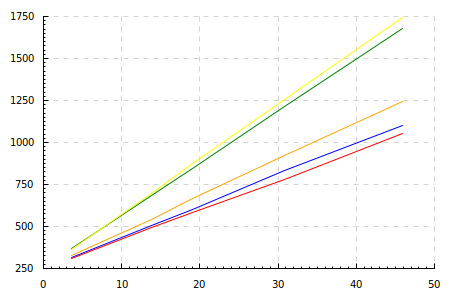

In [5]:
(x,betaMu,betaSigma,beta,ySigma,ys) <- simulate (birats 5 5)
toRenderable $ sequence_ [plot $ line "" [sort $ list x `zip` y] | y <- list ys :: [[Double]]]

In [6]:
-- http://www.openbugs.net/Examples/BiRatsdata.html
biratsX = [8.0, 15.0, 22.0, 29.0, 36.0]
biratsY = [
  [151, 199, 246, 283, 320],
  [145, 199, 249, 293, 354],
  [147, 214, 263, 312, 328],
  [155, 200, 237, 272, 297],
  [135, 188, 230, 280, 323],
  [159, 210, 252, 298, 331],
  [141, 189, 231, 275, 305],
  [159, 201, 248, 297, 338],
  [177, 236, 285, 350, 376],
  [134, 182, 220, 260, 296],
  [160, 208, 261, 313, 352],
  [143, 188, 220, 273, 314],
  [154, 200, 244, 289, 325],
  [171, 221, 270, 326, 358],
  [163, 216, 242, 281, 312],
  [160, 207, 248, 288, 324],
  [142, 187, 234, 280, 316],
  [156, 203, 243, 283, 317],
  [157, 212, 259, 307, 336],
  [152, 203, 246, 286, 321],
  [154, 205, 253, 298, 334],
  [139, 190, 225, 267, 302],
  [146, 191, 229, 272, 302],
  [157, 211, 250, 285, 323],
  [132, 185, 237, 286, 331],
  [160, 207, 257, 303, 345],
  [169, 216, 261, 295, 333],
  [157, 205, 248, 289, 316],
  [137, 180, 219, 258, 291],
  [153, 200, 244, 286, 324]]

In [7]:
let n = length biratsY
    t = length biratsX
    prior = birats (integer n) (integer t)
    posterior = [ (bm,bs,b,sd) | (x,bm,bs,b,sd,y) <- prior, x == list biratsX, y == list biratsY ]

In [8]:
let initial = (list [0,0], eye 2, list (replicate n [1,1]), 1) :: (RVec,RMat,RMat,R)

In [9]:
samples <- hmcStanInit 1000 posterior initial
print $ last samples

--- Generating Stan code ---
data {
  vector[5] x_stan_0_0;
  
  
  
  
  
  matrix[30,5] x_stan_0_6;
}
parameters {
  
  vector[2] x_stan_0_1;
  vector[2] x_stan_0_2;
  corr_matrix[2] x_stan_0_3;
  matrix[30,2] x_stan_0_4;
  real<lower=0> x_stan_0_5;
  
}
model {
  
  matrix[2,30] v_0_1;
  matrix[30,1] v_0_2;
  matrix[30,1] v_0_3;
  
  matrix[1,5] v_0_5;
  matrix[30,5] v_0_6;
  matrix[30,5] v_0_7;
  
  matrix[30,5] v_0_9;
  
  
  
  matrix[2,2] v_0_13;
  vector[2] v_0_14;
  vector[2] v_0_15;
  
  
  
  v_0_1 = x_stan_0_4';
  v_0_2 = to_matrix(to_vector(v_0_1[1]));
  v_0_3 = to_matrix(to_vector(v_0_1[2]));
  
  v_0_5 = to_matrix(to_row_vector(x_stan_0_0));
  v_0_6 = to_matrix(v_0_3) * to_matrix(v_0_5);
  v_0_7 = rep_matrix(to_vector(v_0_2), 5) + v_0_6;
  
  for (i_1_1 in 1:30) for (i_1_2 in 1:5) {
  
    v_0_9[i_1_1, i_1_2] = x_stan_0_5;
  }
  
  
  
  v_0_13 = quad_form_diag(x_stan_0_3, x_stan_0_2);
  for (i_1_1 in 1:2) {
  
    v_0_14[i_1_1] = 0;
  }
  for (i_1_1 in 1:2) {
  
    v_0

([104.639,6.33149],[[135.57807844,-5.944705082836486],[-5.944705082836486,0.6518915304039999]],[[99.4325,6.38386],[91.3923,7.00401],[101.771,6.81125],[107.228,5.47218],[78.4097,7.14034],[111.988,6.22571],[99.0285,5.81951],[95.9207,6.78053],[117.306,7.49154],[98.8741,5.32688],[94.8058,7.65448],[96.4247,6.10042],[104.098,6.25678],[117.772,6.69302],[131.797,5.01399],[126.627,5.56047],[99.0814,6.09183],[107.099,6.11271],[112.064,6.43936],[111.084,5.99643],[116.036,6.25897],[95.0701,5.95259],[106.196,5.46068],[119.844,5.66106],[83.2827,6.92215],[107.478,6.64509],[108.289,6.5509],[120.509,5.51061],[96.445,5.30583],[105.957,6.38429]],6.85353)

In [10]:
import Language.PyMC3
let method = defaultPyMC3Inference{pmTune = 1000, pmDraws = 1000, pmInit = Just "adapt_diag"}
putStrLn $ pmProgram' method posterior (Just initial)
samples <- runPyMC3   method posterior (Just initial)
print $ last samples

import numpy as np
import pymc3 as pm
import sys
import theano
import theano.tensor as tt
import theano.tensor.basic
import theano.tensor.slinalg
from theano.ifelse import ifelse

def ascolumn(a): return a.dimshuffle(0,'x')
def asrow(a):    return a.dimshuffle('x',0)
def quad_form_diag(m,v):
  d = theano.tensor.basic.diag(v)
  return d.dot(m).dot(d)
def lkj_corr(name, eta, n):
  C_triu = pm.LKJCorr(name + '_triu', eta=eta, n=n)
  shape = n * (n - 1) // 2
  tri_index = np.zeros([n, n], dtype='int32')
  tri_index[np.triu_indices(n, k=1)] = np.arange(shape)
  tri_index[np.triu_indices(n, k=1)[::-1]] = np.arange(shape)
  return pm.Deterministic(name, tt.fill_diagonal(C_triu[tri_index], 1))

theano.config.floatX = 'float32'

with pm.Model() as model:
  v_0_0 = 0.0 * np.ones((5), dtype='float32')
  v_0_1 = 50.0 * np.ones((5), dtype='float32')
  x_pm_0_0 = tt.as_tensor_variable(np.load('x_pm_0_0.npy').astype('float32'))
  v_0_3 = 0.0 * np.ones((2), dtype='float32')
  v_0_4 = 100.0 * np.ones((

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_pm_0_5, x_pm_0_4, x_pm_0_3_triu, x_pm_0_2, x_pm_0_1]
100%|##########| 2000/2000 [01:24<00:00, 23.77it/s]

([106.12870788574219,6.176269054412842],[[179.52633084787612,-3.654226198487391],[-3.654226198487391,0.37801998106516876]],[[100.14073181152344,6.276525020599365],[92.91806030273438,6.9047698974609375],[111.09143829345703,6.398200988769531],[118.18741607666016,4.951635837554932],[96.60414123535156,6.232805252075195],[123.55949401855469,5.8622918128967285],[100.26799774169922,5.945618629455566],[107.8413314819336,6.354674339294434],[113.60363006591797,7.7954325675964355],[86.55085754394531,5.811081886291504],[100.1036376953125,7.096543312072754],[103.55410766601563,5.6233229637146],[103.59244537353516,6.246775150299072],[119.96098327636719,6.750241756439209],[121.64537811279297,5.499698638916016],[122.6130142211914,5.80035400390625],[94.9382553100586,6.170075416564941],[129.95262145996094,5.122820854187012],[115.74018096923828,6.259227275848389],[109.01227569580078,6.124212265014648],[108.5250015258789,6.398806571960449],[92.0733413696289,5.973320007324219],[104.12140655517578,5.6300120